In [76]:
from google.colab import files
uploaded = files.upload()

Saving biases_conv1_64.txt to biases_conv1_64.txt
Saving biases_conv2_32.txt to biases_conv2_32.txt
Saving biases_conv3_1.txt to biases_conv3_1.txt
Saving weights_conv1_9x9x1x64.txt to weights_conv1_9x9x1x64.txt
Saving weights_conv2_5x5x64x32.txt to weights_conv2_5x5x64x32.txt
Saving weights_conv3_5x5x32x1.txt to weights_conv3_5x5x32x1.txt


In [77]:
!mkdir -p /content/model
!mv /content/weights_conv1_9x9x1x64.txt /content/model/
!mv /content/biases_conv1_64.txt /content/model/
!mv /content/weights_conv2_5x5x64x32.txt /content/model/
!mv /content/biases_conv2_32.txt /content/model/
!mv /content/weights_conv3_5x5x32x1.txt /content/model/
!mv /content/biases_conv3_1.txt /content/model/

In [78]:
!ls -l /content/model

total 1200
-rw-r--r-- 1 root root    1330 Aug 19 11:03 biases_conv1_64.txt
-rw-r--r-- 1 root root     670 Aug 19 11:03 biases_conv2_32.txt
-rw-r--r-- 1 root root      19 Aug 19 11:03 biases_conv3_1.txt
-rw-r--r-- 1 root root  107557 Aug 19 11:03 weights_conv1_9x9x1x64.txt
-rw-r--r-- 1 root root 1084858 Aug 19 11:03 weights_conv2_5x5x64x32.txt
-rw-r--r-- 1 root root   17060 Aug 19 11:03 weights_conv3_5x5x32x1.txt


In [79]:
from google.colab import files
uploaded = files.upload()

Saving baby_512x512_input.bmp to baby_512x512_input (3).bmp


In [80]:
%%writefile Imagelib.h
#pragma once

#include <cstdint>
#include <cstdio>
#include <cstdlib>
#include <cstring>
#include <cassert>
#include <iostream>
#include <algorithm>
#include <fstream>
#include <string>
#include <vector>
#include <iomanip>

using byte = unsigned char;

#define LOG_OUT(_x_)
#define LOG_OUT_W(_x_)
#define LOG_OUT_A(_x_)

#pragma pack(push, 1)
struct BITMAPFILEHEADER {
    uint16_t bfType;
    uint32_t bfSize;
    uint16_t bfReserved1;
    uint16_t bfReserved2;
    uint32_t bfOffBits;
};

struct BITMAPINFOHEADER {
    uint32_t biSize;
    int32_t  biWidth;
    int32_t  biHeight;
    uint16_t biPlanes;
    uint16_t biBitCount;
    uint32_t biCompression;
    uint32_t biSizeImage;
    int32_t  biXPelsPerMeter;
    int32_t  biYPelsPerMeter;
    uint32_t biClrUsed;
    uint32_t biClrImportant;
};
#pragma pack(pop)

static inline uint32_t row_stride_24(int w) {
    return (uint32_t)(((w * 3) + 3) & ~3u);
}

// ---- 선언 ----
bool LoadBmp(const char* filename, byte** pImage, int& height, int& width);
bool SaveBmp(const char* filename, byte* pImage, int height, int width);
bool convert1Dto2D(byte* src, double** dst_Y, double** dst_U, double** dst_V, int height, int width);
bool convert2Dto1D(double** src_Y, double** src_U, double** src_V, byte* dst, int height, int width);

void convert2Dto3D(double **src2D, double ***dst3D, int height, int width);
void convert3Dto2D(double ***src3D, double **dst2D, int height, int width);

double *dmatrix1D(int nH);
double **dmatrix2D(int nH, int nW);
double ***dmatrix3D(int nH, int nW, int nC);
double ****dmatrix4D(int nH, int nW, int nC, int nNum);

void free_dmatrix1D(double *Image, int nH);
void free_dmatrix2D(double **Image, int nH, int nW);
void free_dmatrix3D(double ***Image, int nH, int nW, int nC);
void free_dmatrix4D(double ****Image, int nH, int nW, int nC, int nNum);

double clip(double x, double minVal, double maxVal);
double** simpleUpsampling2x(double **Image, int nH, int nW);

// ---- 정의 ----
bool LoadBmp(const char* filename, byte** pImage, int& height, int& width) {
    *pImage = nullptr;
    std::FILE* fp = std::fopen(filename, "rb");
    if (!fp) { LOG_OUT_A("fopen() error"); return false; }

    BITMAPFILEHEADER bmf{};
    BITMAPINFOHEADER bmi{};

    if (std::fread(&bmf, sizeof(bmf), 1, fp) != 1) { std::fclose(fp); return false; }
    if (bmf.bfType != 0x4D42) { std::fclose(fp); LOG_OUT_A("not .bmp file"); return false; }

    if (std::fread(&bmi, sizeof(bmi), 1, fp) != 1) { std::fclose(fp); return false; }
    if (bmi.biBitCount != 24 || bmi.biCompression != 0 /*BI_RGB*/) {
        std::fclose(fp); LOG_OUT_A("only 24-bit BI_RGB supported"); return false;
    }

    width  = bmi.biWidth;
    height = (bmi.biHeight >= 0) ? bmi.biHeight : -bmi.biHeight;
    const bool bottom_up = (bmi.biHeight > 0);

    const uint32_t stride = row_stride_24(width);
    const uint32_t data_bytes = stride * (uint32_t)height;

    if (bmf.bfOffBits > sizeof(bmf) + sizeof(bmi)) {
        std::fseek(fp, (long)bmf.bfOffBits, SEEK_SET);
    }

    std::vector<unsigned char> buf(data_bytes);
    if (std::fread(buf.data(), 1, data_bytes, fp) != data_bytes) { std::fclose(fp); return false; }
    std::fclose(fp);

    *pImage = (byte*)std::malloc((size_t)width * height * 3);
    if (!*pImage) return false;

    for (int y = 0; y < height; ++y) {
        int src_y = bottom_up ? (height - 1 - y) : y;
        const unsigned char* src = buf.data() + (size_t)src_y * stride;
        byte* dst = *pImage + (size_t)y * width * 3;
        std::memcpy(dst, src, (size_t)width * 3);
    }
    return true;
}

bool SaveBmp(const char* filename, byte* pImage, int height, int width) {
    // pImage: top→bottom, 패딩 없음, BGR 연속
    const uint32_t stride = row_stride_24(width);
    const uint32_t data_bytes = stride * (uint32_t)height;

    BITMAPFILEHEADER bmf{};
    BITMAPINFOHEADER bmi{};

    bmi.biSize = sizeof(BITMAPINFOHEADER);
    bmi.biWidth = width;
    bmi.biHeight = height;        // bottom-up 저장(양수)
    bmi.biPlanes = 1;
    bmi.biBitCount = 24;
    bmi.biCompression = 0;        // BI_RGB
    bmi.biSizeImage = data_bytes;

    bmf.bfType = 0x4D42; // 'BM'
    bmf.bfOffBits = sizeof(BITMAPFILEHEADER) + sizeof(BITMAPINFOHEADER);
    bmf.bfSize = bmf.bfOffBits + data_bytes;

    std::FILE* fp = std::fopen(filename, "wb");
    if (!fp) { LOG_OUT_A("fopen() error"); return false; }

    std::fwrite(&bmf, 1, sizeof(bmf), fp);
    std::fwrite(&bmi, 1, sizeof(bmi), fp);

    std::vector<unsigned char> row(stride, 0);
    for (int y = height - 1; y >= 0; --y) {
        const byte* src = pImage + (size_t)y * width * 3;
        std::memcpy(row.data(), src, (size_t)width * 3);
        std::fwrite(row.data(), 1, stride, fp);
    }
    std::fclose(fp);
    return true;
}

bool convert1Dto2D(byte* src, double** dst_Y, double** dst_U, double** dst_V, int height, int width) {
    int iR, iG, iB;
    for (int y = 0; y < height; y++) {
        for (int x = 0; x < width; x++) {
            iB = src[3 * width * y + 3 * x + 0];
            iG = src[3 * width * y + 3 * x + 1];
            iR = src[3 * width * y + 3 * x + 2];

            dst_Y[y][x] = iR * 0.299 + iG * 0.587 + iB * 0.114;
            dst_U[y][x] = (iB - dst_Y[y][x]) * 0.565;
            dst_V[y][x] = (iR - dst_Y[y][x]) * 0.713;

            dst_Y[y][x] = dst_Y[y][x] / 255.0; // [0,255] → [0,1]
        }
    }
    return true;
}

bool convert2Dto1D(double** src_Y, double** src_U, double** src_V, byte* dst, int height, int width) {
    int iCount = 0;
    int iR, iG, iB;
    for (int y = 0; y < height; y++) {
        for (int x = 0; x < width; x++) {
            double Y = src_Y[y][x] * 255.0;
            iR = (int)clip(Y + 1.403 * src_V[y][x], 0, 255);
            iG = (int)clip(Y - 0.344 * src_U[y][x] - 0.714 * src_V[y][x], 0, 255);
            iB = (int)clip(Y + 1.770 * src_U[y][x], 0, 255);

            dst[iCount + 0] = (byte)iB;
            dst[iCount + 1] = (byte)iG;
            dst[iCount + 2] = (byte)iR;
            iCount += 3;
        }
    }
    return true;
}

double clip(double x, double minVal, double maxVal) {
    if (x < minVal) x = minVal;
    if (x > maxVal) x = maxVal;
    return x;
}

double** simpleUpsampling2x(double **Image, int nH, int nW) {
    double** outImg = dmatrix2D(nH * 2, nW * 2);
    for (int y = 0; y < nH; y++) {
        for (int x = 0; x < nW; x++) {
            outImg[2 * y + 0][2 * x + 0] = Image[y][x];
            outImg[2 * y + 0][2 * x + 1] = Image[y][x];
            outImg[2 * y + 1][2 * x + 0] = Image[y][x];
            outImg[2 * y + 1][2 * x + 1] = Image[y][x];
        }
    }
    return outImg;
}

double *dmatrix1D(int nH) {
    return new double[nH]();
}

double **dmatrix2D(int nH, int nW) {
    double **Temp = new double*[nH];
    for (int y = 0; y < nH; y++) Temp[y] = new double[nW]();
    return Temp;
}

double ***dmatrix3D(int nH, int nW, int nC) {
    double ***Temp = new double**[nH];
    for (int y = 0; y < nH; y++) {
        Temp[y] = new double*[nW];
        for (int x = 0; x < nW; x++) Temp[y][x] = new double[nC]();
    }
    return Temp;
}

double ****dmatrix4D(int nH, int nW, int nC, int nNum) {
    double ****Temp = new double***[nH];
    for (int y = 0; y < nH; y++) {
        Temp[y] = new double**[nW];
        for (int x = 0; x < nW; x++) {
            Temp[y][x] = new double*[nC];
            for (int c = 0; c < nC; c++) Temp[y][x][c] = new double[nNum]();
        }
    }
    return Temp;
}

void free_dmatrix1D(double *Image, int) { delete[] Image; }

void free_dmatrix2D(double **Image, int nH, int) {
    for (int y = 0; y < nH; y++) delete[] Image[y];
    delete[] Image;
}

void free_dmatrix3D(double ***Image, int nH, int nW, int) {
    for (int y = 0; y < nH; y++) {
        for (int x = 0; x < nW; x++) delete[] Image[y][x];
        delete[] Image[y];
    }
    delete[] Image;
}

void free_dmatrix4D(double ****Image, int nH, int nW, int nC, int) {
    for (int y = 0; y < nH; y++) {
        for (int x = 0; x < nW; x++) {
            for (int c = 0; c < nC; c++) delete[] Image[y][x][c];
            delete[] Image[y][x];
        }
        delete[] Image[y];
    }
    delete[] Image;
}

void convert2Dto3D(double **src2D, double ***dst3D, int height, int width) {
    for (int y = 0; y < height; y++)
        for (int x = 0; x < width; x++)
            dst3D[y][x][0] = src2D[y][x];
}

void convert3Dto2D(double ***src3D, double **dst2D, int height, int width) {
    for (int y = 0; y < height; y++)
        for (int x = 0; x < width; x++)
            dst2D[y][x] = src3D[y][x][0];
}

Overwriting Imagelib.h


In [81]:
%%writefile CTensor.h

#pragma once
#include "Imagelib.h"
#include <iostream>

class Tensor3D {
private:
    double*** tensor;
    int nH; // height
    int nW; // width
    int nC; // channel

public:

    Tensor3D(int _nH, int _nW, int _nC) : tensor(nullptr), nH(_nH), nW(_nW), nC(_nC) {
        tensor = dmatrix3D(nH, nW, nC);
        for (int h = 0; h < nH; ++h) {
            for (int w = 0; w < nW; ++w) {
                for (int c = 0; c < nC; ++c) {
                    tensor[h][w][c] = 0.0;
                }
            }
        }
    }

    ~Tensor3D() {
        if (tensor) {
            free_dmatrix3D(tensor, nH, nW, nC);
            tensor = nullptr;
        }
    }


    inline void set_elem(int _h, int _w, int _c, double _val) { tensor[_h][_w][_c] = _val; }

    inline double get_elem(int _h, int _w, int _c) const {
        return tensor[_h][_w][_c];
    }

    inline void get_info(int& _nH, int& _nW, int& _nC) const {
        _nH = nH; _nW = nW; _nC = nC;
    }

    inline void set_tensor(double*** _tensor) { tensor = _tensor; }
    inline double*** get_tensor() const { return tensor; }

    void print() const {
        std::cout << "Tensor3D size: "
                  << nH << " x " << nW << " x " << nC
                  << " (" << static_cast<long long>(nH) * nW * nC << " elements)"
                  << std::endl;
    }
};

Overwriting CTensor.h


In [82]:
%%writefile CLayer.h
#pragma once
#include <iostream>
#include <fstream>
#include <stdexcept>
#include <string>
#include <omp.h>
#include "Imagelib.h"
#include "CTensor.h"

#define MEAN_INIT 0
#define LOAD_INIT 1

using std::cout;
using std::endl;
using std::string;

class Layer {
protected:
    int fK;
    int fC_in;
    int fC_out;
    string name;
public:
    Layer(string _name, int _fK, int _fC_in, int _fC_out)
        : name(_name), fK(_fK), fC_in(_fC_in), fC_out(_fC_out) {}
    virtual ~Layer() {}
    virtual Tensor3D* forward(const Tensor3D* input) = 0;
    virtual void print() const = 0;
    virtual void get_info(string& _name, int& _fK, int& _fC_in, int& _fC_out) const = 0;
};

class Layer_ReLU : public Layer {
public:
    Layer_ReLU(string _name, int _fK, int _fC_in, int _fC_out)
        : Layer(_name, _fK, _fC_in, _fC_out) {}
    ~Layer_ReLU() {}

    Tensor3D* forward(const Tensor3D* input) override {
        int nH, nW, nC;
        input->get_info(nH, nW, nC);
        Tensor3D* output = new Tensor3D(nH, nW, nC);

        #pragma omp parallel for collapse(3) schedule(static)
        for (int h = 0; h < nH; ++h)
            for (int w = 0; w < nW; ++w)
                for (int c = 0; c < nC; ++c) {
                    double x = input->get_elem(h, w, c);
                    output->set_elem(h, w, c, x > 0.0 ? x : 0.0);
                }

        cout << name << " is finished" << endl;
        return output;
    }

    void get_info(string& _name, int& _fK, int& _fC_in, int& _fC_out) const override {
        _name = name; _fK = fK; _fC_in = fC_in; _fC_out = fC_out;
    }

    void print() const override {
        cout << "[Layer_ReLU] " << name
             << " | fK=" << fK
             << " | C_in=" << fC_in
             << " | C_out=" << fC_out
             << endl;
    }
};

class Layer_Conv : public Layer {
private:
    string filename_weight;
    string filename_bias;
    double**** weight_tensor;
    double*   bias_tensor;
    double    out_scale;
    bool      zero_init;

    void init(int init_type) {
        weight_tensor = dmatrix4D(fK, fK, fC_in, fC_out);
        bias_tensor   = dmatrix1D(fC_out);

        if (zero_init) {
            for (int kh=0; kh<fK; ++kh)
                for (int kw=0; kw<fK; ++kw)
                    for (int ic=0; ic<fC_in; ++ic)
                        for (int oc=0; oc<fC_out; ++oc)
                            weight_tensor[kh][kw][ic][oc] = 0.0;
            for (int oc=0; oc<fC_out; ++oc) bias_tensor[oc] = 0.0;
            return;
        }

        if (init_type == MEAN_INIT) {
            const double val = 1.0 / static_cast<double>(fK * fK * fC_in);
            for (int kh=0; kh<fK; ++kh)
                for (int kw=0; kw<fK; ++kw)
                    for (int ic=0; ic<fC_in; ++ic)
                        for (int oc=0; oc<fC_out; ++oc)
                            weight_tensor[kh][kw][ic][oc] = val;
            for (int oc=0; oc<fC_out; ++oc) bias_tensor[oc] = 0.0;
        } else if (init_type == LOAD_INIT) {
            if (filename_weight.empty() || filename_bias.empty())
                throw std::runtime_error("LOAD_INIT requires valid weight/bias filenames.");

            std::ifstream fw(filename_weight);
            if (!fw.is_open()) throw std::runtime_error("Failed to open weight file: " + filename_weight);
            for (int kh=0; kh<fK; ++kh)
                for (int kw=0; kw<fK; ++kw)
                    for (int ic=0; ic<fC_in; ++ic)
                        for (int oc=0; oc<fC_out; ++oc) {
                            double v;
                            if (!(fw >> v)) throw std::runtime_error("Invalid weight data in " + filename_weight);
                            weight_tensor[kh][kw][ic][oc] = v;
                        }
            fw.close();

            std::ifstream fb(filename_bias);
            if (!fb.is_open()) throw std::runtime_error("Failed to open bias file: " + filename_bias);
            for (int oc=0; oc<fC_out; ++oc) {
                double b;
                if (!(fb >> b)) throw std::runtime_error("Invalid bias data in " + filename_bias);
                bias_tensor[oc] = b;
            }
            fb.close();
        } else {
            throw std::runtime_error("Unknown init_type for Layer_Conv");
        }
    }

public:
    Layer_Conv(string _name, int _fK, int _fC_in, int _fC_out, int init_type,
               string _filename_weight = "", string _filename_bias = "",
               double _out_scale = 1.0, bool _zero_init = false)
        : Layer(_name, _fK, _fC_in, _fC_out),
          filename_weight(_filename_weight),
          filename_bias(_filename_bias),
          weight_tensor(nullptr),
          bias_tensor(nullptr),
          out_scale(_out_scale),
          zero_init(_zero_init)
    {
        init(init_type);
    }

    ~Layer_Conv() override {
        if (weight_tensor) { free_dmatrix4D(weight_tensor, fK, fK, fC_in, fC_out); weight_tensor = nullptr; }
        if (bias_tensor)   { free_dmatrix1D(bias_tensor, fC_out); bias_tensor = nullptr; }
    }

    Tensor3D* forward(const Tensor3D* input) override {
        int inH, inW, inC;
        input->get_info(inH, inW, inC);
        if (inC != fC_in) throw std::runtime_error("Conv: input channel mismatch.");

        const int pad = fK / 2;      // SAME padding
        const int outH = inH;
        const int outW = inW;
        Tensor3D* output = new Tensor3D(outH, outW, fC_out);

        #pragma omp parallel for collapse(3) schedule(dynamic,16)
        for (int h=0; h<outH; ++h){
            for (int w=0; w<outW; ++w){
                for (int oc=0; oc<fC_out; ++oc){
                    double acc = bias_tensor[oc];
                    for (int kh=0; kh<fK; ++kh){
                        for (int kw=0; kw<fK; ++kw){
                            for (int ic=0; ic<fC_in; ++ic){
                                int ih = h + kh - pad;
                                int iw = w + kw - pad;
                                if (ih < 0 || iw < 0 || ih >= inH || iw >= inW) continue; // zero-pad
                                double x = input->get_elem(ih, iw, ic);
                                acc += weight_tensor[kh][kw][ic][oc] * x;
                            }
                        }
                    }
                    output->set_elem(h, w, oc, acc * out_scale);
                }
            }
        }
        cout << name << " is finished" << endl;
        return output;
    }

    void get_info(string& _name, int& _fK, int& _fC_in, int& _fC_out) const override {
        _name = name; _fK = fK; _fC_in = fC_in; _fC_out = fC_out;
    }

    void print() const override {
        cout << "[Layer_Conv] " << name
             << " | fK=" << fK
             << " | C_in=" << fC_in
             << " | C_out=" << fC_out
             << " | stride=1, padding=SAME"
             << " | out_scale=" << out_scale
             << " | zero_init=" << (zero_init ? "true" : "false")
             << endl;
    }
};

Overwriting CLayer.h


In [83]:
%%writefile CModel.h
#pragma once
#include <vector>
#include <string>
#include <iostream>
#include <iomanip>
#include <stdexcept>
#include <cstdlib>
#include "CLayer.h"
#include "Imagelib.h"

using std::vector;
using std::string;
using std::cout;
using std::endl;
using std::setw;

class Model {
private:
    vector<Layer*>    layers;
    vector<Tensor3D*> tensors;

public:
    Model() {}
    void add_layer(Layer* layer) { layers.push_back(layer); }

    ~Model() {
        for (auto* t : tensors) delete t;
        for (auto* l : layers)  delete l;
    }

    static void read_image(const string& filename,
                           byte*& pLoadImage,
                           double**& img_Y, double**& img_U, double**& img_V,
                           int& nH, int& nW)
    {
        if (!LoadBmp(filename.c_str(), &pLoadImage, nH, nW))
            throw std::runtime_error("LoadBmp failed: " + filename);

        img_Y = dmatrix2D(nH, nW);
        img_U = dmatrix2D(nH, nW);
        img_V = dmatrix2D(nH, nW);
        convert1Dto2D(pLoadImage, img_Y, img_U, img_V, nH, nW);
    }

    static void save_image(const string& filename,
                           double** img_Y,
                           double** img_U, double** img_V,
                           int nH, int nW)
    {
        byte* outBGR = (byte*)std::malloc((size_t)nH * nW * 3);
        convert2Dto1D(img_Y, img_U, img_V, outBGR, nH, nW);
        SaveBmp(filename.c_str(), outBGR, nH, nW);
        std::free(outBGR);
    }

    void test(const string& filename_input, const string& filename_output) {
        int nH = 0, nW = 0;
        double **Y = nullptr, **U = nullptr, **V = nullptr;
        byte* pLoadImage = nullptr;

        read_image(filename_input, pLoadImage, Y, U, V, nH, nW);
        cout << "Reading (" << filename_input << ") is complete..." << endl;

        for (auto* t : tensors) delete t;
        tensors.clear();

        Tensor3D* tin = new Tensor3D(nH, nW, 1);
        for (int h = 0; h < nH; ++h)
            for (int w = 0; w < nW; ++w)
                tin->set_elem(h, w, 0, Y[h][w]);  // [0,1]
        tensors.push_back(tin);

        for (size_t i = 0; i < layers.size(); ++i) {
            Tensor3D* in  = tensors.back();
            Tensor3D* out = layers[i]->forward(in);
            tensors.push_back(out);
        }

        // 잔차 결합: y = x + res_scale * f(x)
        Tensor3D* input_tensor    = tensors.at(0);
        Tensor3D* residual_tensor = tensors.back();

        int H, W, C;
        input_tensor->get_info(H, W, C);
        Tensor3D* final_image_tensor = new Tensor3D(H, W, C);

        const double res_scale = 0.1;

        for (int h = 0; h < H; ++h) {
            for (int w = 0; w < W; ++w) {
                double y_in  = input_tensor->get_elem(h, w, 0);   // [0,1]
                double y_res = residual_tensor->get_elem(h, w, 0);
                double val   = y_in + res_scale * y_res;
                if (val < 0.0) val = 0.0;
                if (val > 1.0) val = 1.0;
                final_image_tensor->set_elem(h, w, 0, val);
            }
        }
        tensors.push_back(final_image_tensor);

        cout << "Super-resolution is complete..." << endl;

        double** Y_out = dmatrix2D(H, W);
        for (int h = 0; h < H; ++h)
            for (int w = 0; w < W; ++w)
                Y_out[h][w] = final_image_tensor->get_elem(h, w, 0);

        save_image(filename_output, Y_out, U, V, H, W);
        cout << "Saving (" << filename_output << ") is complete..." << endl;

        if (pLoadImage) { std::free(pLoadImage); pLoadImage = nullptr; }
        if (Y) free_dmatrix2D(Y, nH, nW);
        if (U) free_dmatrix2D(U, nH, nW);
        if (V) free_dmatrix2D(V, nH, nW);
        if (Y_out) free_dmatrix2D(Y_out, H, W);
    }

    void print_layer_info() const {
        cout << "\n(Layer information)\n"
             << "-----------------------------\n";
        for (unsigned i = 0; i < layers.size(); ++i) {
            string name; int k, cin_, cout_;
            layers[i]->get_info(name, k, cin_, cout_);
            cout << (i + 1) << "-th layer: "
                 << std::left << setw(8) << (name + ":")
                 << k << "*" << k << "*" << cin_ << "*" << cout_ << "\n";
        }
    }

    void print_tensor_info() const {
        cout << "\n(Tensor information)\n"
             << "-----------------------------\n";
        for (unsigned i = 0; i < tensors.size(); ++i) {
            int H, W, C;
            tensors[i]->get_info(H, W, C);
            cout << (i + 1) << "-th tensor: "
                 << H << "*" << W << "*" << C << "\n";
        }
    }
};

Overwriting CModel.h


In [84]:
%%writefile main.cpp
#include <iostream>
#include <vector>
#include <string>
#include <fstream>
#include <sstream>
#include <chrono>
#include <cmath>
#include <thread>
#include <iomanip>
#include <cstdio>
#include <omp.h>

#include "Imagelib.h"
#include "CModel.h"

using namespace std;

static string read_first_match(const string& path, const string& key) {
    ifstream f(path);
    string line;
    while (getline(f, line)) {
        if (line.find(key) != string::npos) return line;
    }
    return "";
}

static string cpu_name() {
    string line = read_first_match("/proc/cpuinfo", "model name");
    if (line.empty()) return "Unknown CPU";
    auto pos = line.find(':');
    return (pos == string::npos) ? line : string(line.begin() + pos + 2, line.end());
}

static long mem_total_mb() {
    string line = read_first_match("/proc/meminfo", "MemTotal:");
    if (line.empty()) return -1;
    istringstream iss(line);
    string label; long kb=0;
    iss >> label >> kb;
    return kb / 1024;
}

static string run_cmd(const char* cmd) {
    string out;
    FILE* pipe = popen(cmd, "r");
    if (!pipe) return "";
    char buf[512];
    while (fgets(buf, sizeof(buf), pipe)) out += buf;
    pclose(pipe);
    if (!out.empty() && (out.back()=='\n' || out.back()=='\r')) out.pop_back();
    return out;
}

static string gpu_info() {
    string q = run_cmd(
        "command -v nvidia-smi >/dev/null 2>&1 && "
        "nvidia-smi --query-gpu=name,driver_version,memory.total "
        "--format=csv,noheader,nounits | head -n 1"
    );
    if (q.empty()) return "None";

    istringstream iss(q);
    string name, driver, mem;
    getline(iss, name, ',');
    getline(iss, driver, ',');
    getline(iss, mem, ',');
    auto trim = [](string& s){
        while(!s.empty() && isspace((unsigned char)s.front())) s.erase(s.begin());
        while(!s.empty() && isspace((unsigned char)s.back()))  s.pop_back();
    };
    trim(name); trim(driver); trim(mem);
    if (mem.empty()) return name + ", " + driver;
    return name + ", " + driver + " , " + mem + " MiB";
}

struct BenchResult {
    double ms_fill_serial=0, ms_sum_serial=0, ms_total_serial=0;
    double ms_fill_parallel=0, ms_sum_parallel=0, ms_total_parallel=0;
    long double sum_serial=0, sum_parallel=0;
};

static BenchResult benchmark_tensor(size_t H, size_t W, size_t C) {
    const size_t N = H * W * C;
    vector<double> a(N, 0.0);

    auto now = [](){ return chrono::high_resolution_clock::now(); };
    auto ms  = [](auto dt){ return chrono::duration_cast<chrono::milliseconds>(dt).count(); };

    BenchResult r;

    auto t0 = now();
    for (size_t i=0; i<N; ++i) {
        a[i] = (double)((i % 1000) - 500) * 0.125 + sin((double)i * 1e-6);
    }
    auto t1 = now();
    r.ms_fill_serial = ms(t1 - t0);

    long double ssum = 0.0L;
    auto t2 = now();
    for (size_t i=0; i<N; ++i) ssum += a[i];
    auto t3 = now();
    r.ms_sum_serial = ms(t3 - t2);
    r.ms_total_serial = r.ms_fill_serial + r.ms_sum_serial;
    r.sum_serial = ssum;

    auto t4 = now();
    #pragma omp parallel for schedule(static)
    for (long long i=0; i<(long long)N; ++i) {
        a[i] = (double)((i % 1000) - 500) * 0.125 + sin((double)i * 1e-6);
    }
    auto t5 = now();
    r.ms_fill_parallel = ms(t5 - t4);

    long double psum = 0.0L;
    auto t6 = now();
    #pragma omp parallel for reduction(+:psum) schedule(static)
    for (long long i=0; i<(long long)N; ++i) psum += a[i];
    auto t7 = now();
    r.ms_sum_parallel = ms(t7 - t6);
    r.ms_total_parallel = r.ms_fill_parallel + r.ms_sum_parallel;
    r.sum_parallel = psum;

    return r;
}

int main() {


    Model model;

    model.add_layer(new Layer_Conv("Conv1", 9, 1, 64, LOAD_INIT,
        "model/weights_conv1_9x9x1x64.txt", "model/biases_conv1_64.txt"));
    model.add_layer(new Layer_ReLU("Relu1", 1, 64, 64));
    model.add_layer(new Layer_Conv("Conv2", 5, 64, 32, LOAD_INIT,
        "model/weights_conv2_5x5x64x32.txt", "model/biases_conv2_32.txt"));
    model.add_layer(new Layer_ReLU("Relu2", 1, 32, 32));
    model.add_layer(new Layer_Conv("Conv3", 5, 32, 1, LOAD_INIT,
        "model/weights_conv3_5x5x32x1.txt", "model/biases_conv3_1.txt"));

    try {
        model.test("baby_512x512_input.bmp", "baby_512x512_output_srcnn.bmp");
        model.print_layer_info();
        model.print_tensor_info();
    } catch (const std::exception& e) {
        std::cerr << "Model error: " << e.what() << std::endl;
        return 1;
    }

		const size_t H = 1024, W = 2048, C = 16;
    cout << "===== Benchmark Tensor =====\n";
    cout << "Size: " << H << " x " << W << " x " << C << "\n";

    BenchResult r = benchmark_tensor(H, W, C);

    cout.setf(ios::fixed);
    cout << setprecision(3);
    cout << "Serial  : fill " << r.ms_fill_serial
         << " ms, sum " << r.ms_sum_serial
         << " ms, total " << r.ms_total_serial << " ms\n";
    cout << "Parallel: fill " << r.ms_fill_parallel
         << " ms, sum " << r.ms_sum_parallel
         << " ms, total " << r.ms_total_parallel << " ms\n";

    cout << setprecision(6);
    cout << "sum(serial) = " << (long double)r.sum_serial
         << ", sum(parallel) = " << (long double)r.sum_parallel << "\n";

    cout << setprecision(3);
    double speedup = (r.ms_total_parallel > 0) ? (r.ms_total_serial / r.ms_total_parallel) : 0.0;
    cout << "Speedup (Serial/Parallel): " << speedup << "x\n";


    cout << "===== Hardware Info =====\n";
    cout << "CPU   : " << cpu_name() << "\n";
    long memmb = mem_total_mb();
    if (memmb > 0) cout << "Memory: " << memmb << " MB\n";
#ifdef _OPENMP
    cout << "OpenMP: yes\n";
    cout << "  omp_get_max_threads(): " << omp_get_max_threads() << "\n";
    cout << "  omp_get_num_procs()  : " << omp_get_num_procs() << "\n";
#else
    cout << "OpenMP: no\n";
#endif
    cout << "GPU   : " << gpu_info() << "\n";


    return 0;
}

Overwriting main.cpp


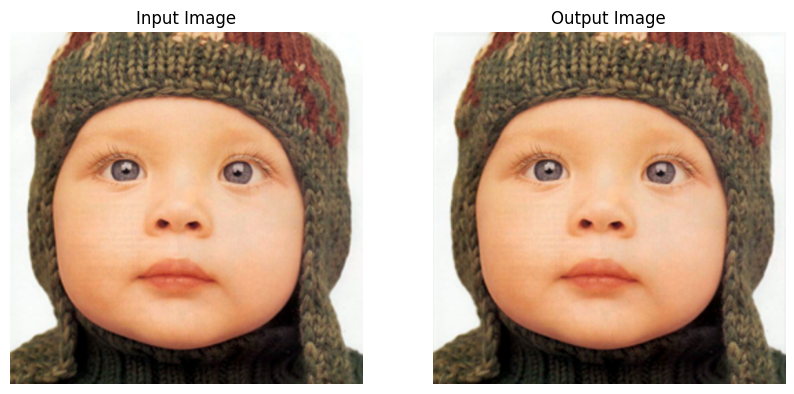

In [85]:
from PIL import Image
import matplotlib.pyplot as plt

in_path  = "baby_512x512_input.bmp"
out_path = "baby_512x512_output_srcnn.bmp"

img_in  = Image.open(in_path)
img_out = Image.open(out_path)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title("Input Image")
plt.imshow(img_in)
plt.axis("off")

plt.subplot(1,2,2)
plt.title("Output Image")
plt.imshow(img_out)
plt.axis("off")

plt.show()

In [89]:
!g++ -O3 -fopenmp main.cpp Imagelib.h -o app
!./app

Imagelib.h:1:9: warning: #pragma once in main file
    1 | #pragma once
      |         ^~~~
Reading (baby_512x512_input.bmp) is complete...
Conv1 is finished
Relu1 is finished
Conv2 is finished
Relu2 is finished
Conv3 is finished
Super-resolution is complete...
Saving (baby_512x512_output_srcnn.bmp) is complete...

(Layer information)
-----------------------------
1-th layer: Conv1:  9*9*1*64
2-th layer: Relu1:  1*1*64*64
3-th layer: Conv2:  5*5*64*32
4-th layer: Relu2:  1*1*32*32
5-th layer: Conv3:  5*5*32*1

(Tensor information)
-----------------------------
1-th tensor: 512*512*1
2-th tensor: 512*512*64
3-th tensor: 512*512*64
4-th tensor: 512*512*32
5-th tensor: 512*512*32
6-th tensor: 512*512*1
7-th tensor: 512*512*1
===== Benchmark Tensor =====
Size: 1024 x 2048 x 16
Serial  : fill 1185.000 ms, sum 163.000 ms, total 1348.000 ms
Parallel: fill 1015.000 ms, sum 60.000 ms, total 1075.000 ms
sum(serial) = 38686124289758123748491264.000000, sum(parallel) = -574786.466690
Speedup (Ser